In [1]:
import warnings
warnings.filterwarnings("ignore")

# Contents
[Data Preprocessing](#Data-Preprocessing)<br>
[Random Forest](#Random-Forest)<br>
[What is Random Forest?](#What-is-Random-Forest?)<br>
[Random Forest Model using Non-Oversampled Data](#Random-Forest-Model-using-Non-Oversampled-Data)<br>
[Random Forest Model using Oversampled Data](#Random-Forest-Model-using-Oversampled-Data)<br>
[Random Forest Observation Non-Oversampled vs Oversampled Dataset](#Random-Forest-Observation-Non-Oversampled-vs-Oversampled-Dataset)<br>
[Random Forest Processed Dataset vs Original Dataset w/ all Features](#Random-Forest-Processed-Dataset-vs-Original-Dataset-w/-all-Features)<br>
[Random Forest Observation Processed Dataset vs Original Dataset w/ all Features](#Random-Forest-Observation-Processed-Dataset-vs-Original-Dataset-w/-all-Features)<br>
[Random Forest Optimization through Random Search](#Random-Forest-Optimization-through-Random-Search)<br>
[Random Forest Optimzied Model Observation](#Random-Forest-Optimzied-Model-Observation)<br>
[Random Forest Conclusion](#Overall-Conclusion)<br>


# Data Preprocessing

In [2]:
# Perform Data Preprocessing
%run ./Preprocess.ipynb

Using TensorFlow backend.


In [3]:
# Perform Data Preprocessing
%run "Preprocess_keep_features_except_geo_2_3.ipynb"

# Random Forest

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools

# Set random seed to ensure reproducible runs
RSEED = 100

In [5]:
# Plot confusion matrix from confusion_matrix object
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('Predicted', size = 18)
    plt.xlabel('Actual', size = 18)

In [6]:
def exec_train_randomForest(train, train_labels, trees = 100):

    # Create the model with 100 trees by default if not specified
    model = RandomForestClassifier(n_estimators=trees, 
                                   random_state=RSEED,
                                   max_features = 'sqrt',
                                   n_jobs=-1, verbose = 1)

    # Fit on training data
    model.fit(train, train_labels)
    
    n_nodes = []
    max_depths = []

    for ind_tree in model.estimators_:
        n_nodes.append(ind_tree.tree_.node_count)
        max_depths.append(ind_tree.tree_.max_depth)

    print(f'Average number of nodes {int(np.mean(n_nodes))}')
    print(f'Average maximum depth {int(np.mean(max_depths))}')
    
    return model

In [7]:
def exec_predict_randomForest(train, train_labels, model, label, print_values = True):
    # Predict using data
    train_rf_predictions = model.predict(train)    
    
    # Formulate and plot the confusion matrix using train-predicted damage_grade against train original damage_grade
    cm_train = confusion_matrix(train_labels, train_rf_predictions)
 
    # Formulate the classification report
    report_train = classification_report(train_labels, train_rf_predictions)
    
    # Formulate the F1 Micro score
    f1_micro_train = f1_score(train_labels, train_rf_predictions, average='micro')
    
    if(print_values):
        print("Comparing predicted against " + label + " dataset :\n")
        
        # Plot Confusion Matrix
        plot_confusion_matrix(cm_train, classes = ['1', '2', '3'], title = 'Damage Grade (' + label + ')')
        print()
        
        # Display classification report
        print(report_train)

        # Display F1 Micro score
        print("F1 Micro Score (" + label + ") : ", f1_micro_train)
        print()

    return report_train, f1_micro_train

In [8]:
def optimize_model(train, train_labels):
    # Hyperparameter grid
    param_grid = {
        'n_estimators': np.linspace(10, 200).astype(int), # Number of forests
        'max_depth': [None] + list(np.linspace(3, 20).astype(int)), # Maximum depth of each tree
        'max_features': ['auto', 'log2', None] + list(np.arange(0.5, 1, 0.1)), # Maximum number of features to consider at each split
        'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)), # Search trees w/ the max_leaf_nodes
        'min_samples_split': [2, 5, 10], # The minimum number of samples required to split an internal node
        'bootstrap': [True, False] # Try growing trees w/ whole dataset and some with partial dataset
    }

    # Estimator for use in random search
    estimator = RandomForestClassifier(random_state = RSEED)

    # Create the random search model to find the best model based on F1 Micro
    rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                            scoring = 'f1_micro', cv = 10, # 10-fold Cross Validation
                            n_iter = 10, verbose = 1, random_state=RSEED)

    # Fit 
    rs.fit(train, train_labels)
    
    # Return the model
    return rs.best_estimator_

# What is Random Forest? 
[Back to top](#Contents)<br>

Random forests are bagged decision tree models that split on a subset of features on each split.

# Random Forest Model using Non-Oversampled Data
[Back to top](#Contents)<br>

In [9]:
# Create and fit Random Forest model based on processed data and output the model

rf_model = exec_train_randomForest(train_x, train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.0s


Average number of nodes 109627
Average maximum depth 68


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.1s finished


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.1s finished


Comparing predicted against Train dataset :

Confusion matrix, without normalization
[[ 16170   3526    360]
 [  1187 108225   9092]
 [   273  13588  56059]]

              precision    recall  f1-score   support

           1       0.92      0.81      0.86     20056
           2       0.86      0.91      0.89    118504
           3       0.86      0.80      0.83     69920

    accuracy                           0.87    208480
   macro avg       0.88      0.84      0.86    208480
weighted avg       0.87      0.87      0.86    208480

F1 Micro Score (Train) :  0.8655698388334613



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.9s finished


Comparing predicted against Test dataset :

Confusion matrix, without normalization
[[ 2190  2683   195]
 [ 1503 22500  5752]
 [  185  7595  9518]]

              precision    recall  f1-score   support

           1       0.56      0.43      0.49      5068
           2       0.69      0.76      0.72     29755
           3       0.62      0.55      0.58     17298

    accuracy                           0.66     52121
   macro avg       0.62      0.58      0.60     52121
weighted avg       0.65      0.66      0.65     52121

F1 Micro Score (Test) :  0.6563189501352622



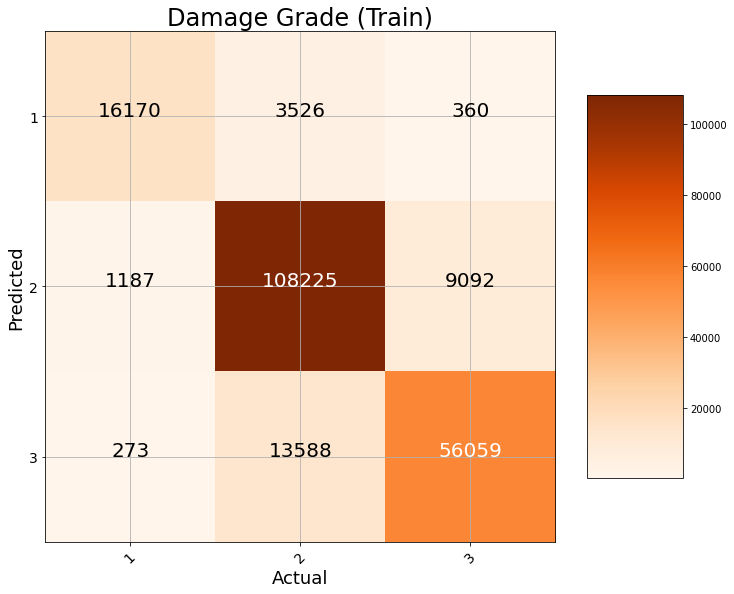

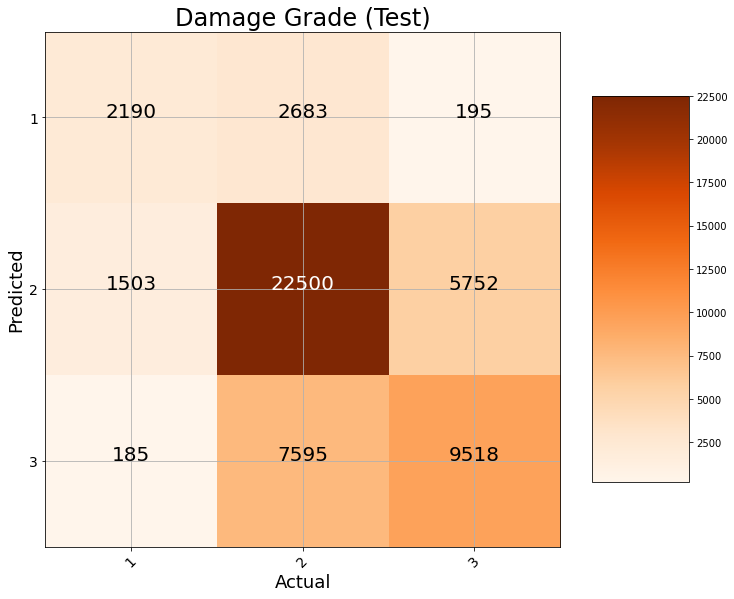

In [10]:
# Use the model to predict and compare train-damage_grade against train-predicted-damage_grade and 
# test-damage_grade against test-predicted-damage_grade
# Plot the confusion matrix & calculate F1 Micro score

normal_train_report, f1_normal_train = exec_predict_randomForest(train_x, train_y, rf_model, "Train")
normal_test_report, f1_normal_test = exec_predict_randomForest(test_x, test_y, rf_model, "Test")

# Random Forest Model using Oversampled Data
[Back to top](#Contents)<br>

In [11]:
# Create and fit Random Forest model based on oversampled processed data and output the model

rf_model_over = exec_train_randomForest(train_x_over, train_y_over)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.8s


Average number of nodes 124329
Average maximum depth 67


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   49.5s finished


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.7s finished


Comparing predicted against Train dataset :

Confusion matrix, without normalization
[[115452   2140    912]
 [  7657  94661  16186]
 [  2675  10479 105350]]

              precision    recall  f1-score   support

           1       0.92      0.97      0.95    118504
           2       0.88      0.80      0.84    118504
           3       0.86      0.89      0.87    118504

    accuracy                           0.89    355512
   macro avg       0.89      0.89      0.89    355512
weighted avg       0.89      0.89      0.89    355512

F1 Micro Score (Train) :  0.8873483876774905



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.1s finished


Comparing predicted against Test dataset :

Confusion matrix, without normalization
[[ 2898  1903   267]
 [ 3537 18511  7707]
 [  599  5935 10764]]

              precision    recall  f1-score   support

           1       0.41      0.57      0.48      5068
           2       0.70      0.62      0.66     29755
           3       0.57      0.62      0.60     17298

    accuracy                           0.62     52121
   macro avg       0.56      0.61      0.58     52121
weighted avg       0.63      0.62      0.62     52121

F1 Micro Score (Test) :  0.6172751865850616



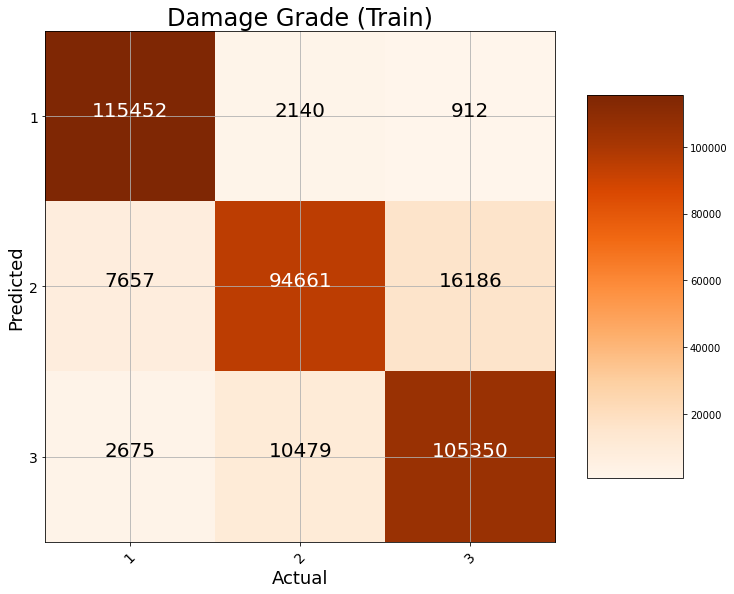

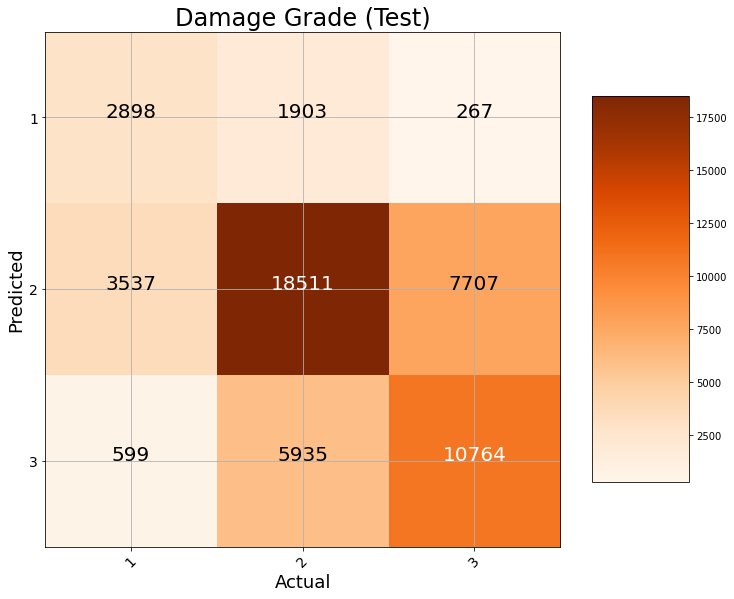

In [12]:
# Use the oversampled-model to predict and compare oversampled-train-damage_grade against train-predicted-damage_grade and 
# test-damage_grade against test-predicted-damage_grade
# Plot the confusion matrix & calculate F1 Micro score

oversampled_train_report, f1_oversampled_train = exec_predict_randomForest(train_x_over, train_y_over, rf_model_over, "Train")
oversampled_test_report, f1_oversampled_test = exec_predict_randomForest(test_x, test_y, rf_model_over, "Test")

# Random Forest Observation Non-Oversampled vs Oversampled Dataset
[Back to top](#Contents)<br>

In [13]:
print("Without Oversampling : ")
print("Train : ")
print(normal_train_report)
print("F1 Micro Score \t\t: " + str(f1_normal_train))
print()
print("Test : ")
print(normal_test_report)
print("F1 Micro Score \t\t: " + str(f1_normal_test))
print()
print("With Oversampling : ")
print("Train : ")
print(oversampled_train_report)
print("F1 Micro Score \t\t: " + str(f1_oversampled_train))
print()
print("Test : ")
print(oversampled_test_report)
print("F1 Micro Score \t\t: " + str(f1_oversampled_test))

Without Oversampling : 
Train : 
              precision    recall  f1-score   support

           1       0.92      0.81      0.86     20056
           2       0.86      0.91      0.89    118504
           3       0.86      0.80      0.83     69920

    accuracy                           0.87    208480
   macro avg       0.88      0.84      0.86    208480
weighted avg       0.87      0.87      0.86    208480

F1 Micro Score 		: 0.8655698388334613

Test : 
              precision    recall  f1-score   support

           1       0.56      0.43      0.49      5068
           2       0.69      0.76      0.72     29755
           3       0.62      0.55      0.58     17298

    accuracy                           0.66     52121
   macro avg       0.62      0.58      0.60     52121
weighted avg       0.65      0.66      0.65     52121

F1 Micro Score 		: 0.6563189501352622

With Oversampling : 
Train : 
              precision    recall  f1-score   support

           1       0.92      0.97 

### Observation
#### Train set with oversampling vs the train set without oversampling
With oversampling, the F1 micro score slightly improved. 
 
Reason : 

RandomOverSampling was used to duplicate data to balance the dataset. However in doing so, this allows the classifier to cheat, because when trying to make predictions on the train set, the classifier will already have seen identical points in the dataset. <br><br>

#### Test set with oversampling vs test set without oversampling
With oversampling, the F1 micro score became worse. <br>

Individual F1 score for each damage grade also decreased with the exception of damage grade 3 that had a slight increase. <br>

A decrease in precision while an increase in recall for the minority classes (damage grade 1 & 3) was observed. <br>

Meanwhile, the majority class (damage grade 3) had a slight increased precision while recall decreased. <br>

#### Precision
Precision = How many correctly identified damage grade 1 were amongst the predicted damage grade 1. <br>

#### Recall
Recall = How many correctly identified damage grade 1 were amongst all the damage grade 1. <br>

As it is important to account for false negatives in this scenario, the increased recall for the minority classes should contribute to the increased in performance but it did not due to the larger decreased precision.

#### Conclusion
Since F1 Micro score was selected as to benchmark the accuracy of the model, training the model with the non-oversampled dataset will be prefered over the oversampled model.

# Random Forest Processed Dataset vs Original Dataset w/ all Features
[Back to top](#Contents)<br>

We will train a model using the original dataset with all the features except geo level 2 & 3 and see if the dropped features affect the model accuracy. <br>
The reason why geo level 2 & 3 were not included was because of the sheer number of columns the dataset contained after one hot encoding geo level 2 & 3.

In [14]:
# Create and fit Random Forest model based on original non-processed data and output the model

rf_model_nodrop = exec_train_randomForest(train_x_keep, train_y_keep)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.6s


Average number of nodes 132377
Average maximum depth 73


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.5s finished


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.9s finished


Comparing predicted against Train dataset :

Confusion matrix, without normalization
[[ 18033   1806    234]
 [   747 112517   5193]
 [   167   7239  62544]]

              precision    recall  f1-score   support

           1       0.95      0.90      0.92     20073
           2       0.93      0.95      0.94    118457
           3       0.92      0.89      0.91     69950

    accuracy                           0.93    208480
   macro avg       0.93      0.91      0.92    208480
weighted avg       0.93      0.93      0.93    208480

F1 Micro Score (Train) :  0.9261991557943207



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.0s finished


Comparing predicted against Test dataset :

Confusion matrix, without normalization
[[ 2232  2634   185]
 [ 1523 22899  5380]
 [  194  7262  9812]]

              precision    recall  f1-score   support

           1       0.57      0.44      0.50      5051
           2       0.70      0.77      0.73     29802
           3       0.64      0.57      0.60     17268

    accuracy                           0.67     52121
   macro avg       0.63      0.59      0.61     52121
weighted avg       0.67      0.67      0.67     52121

F1 Micro Score (Test) :  0.6704207517123616



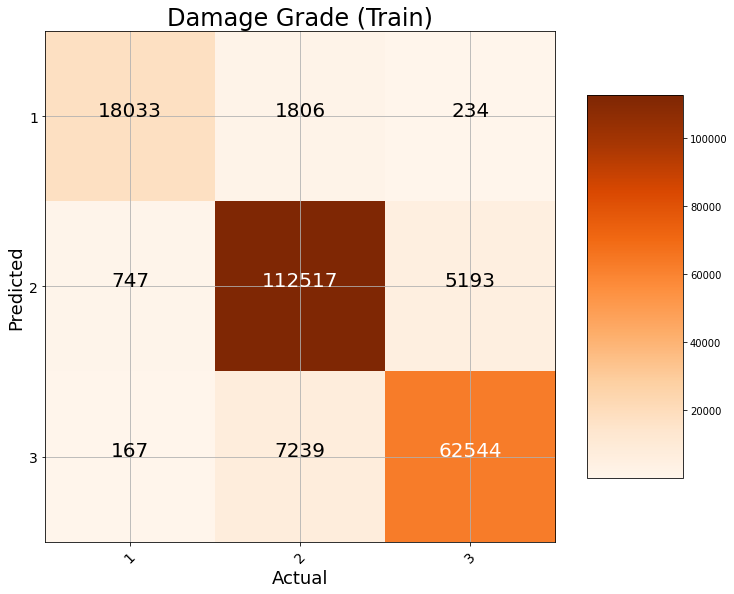

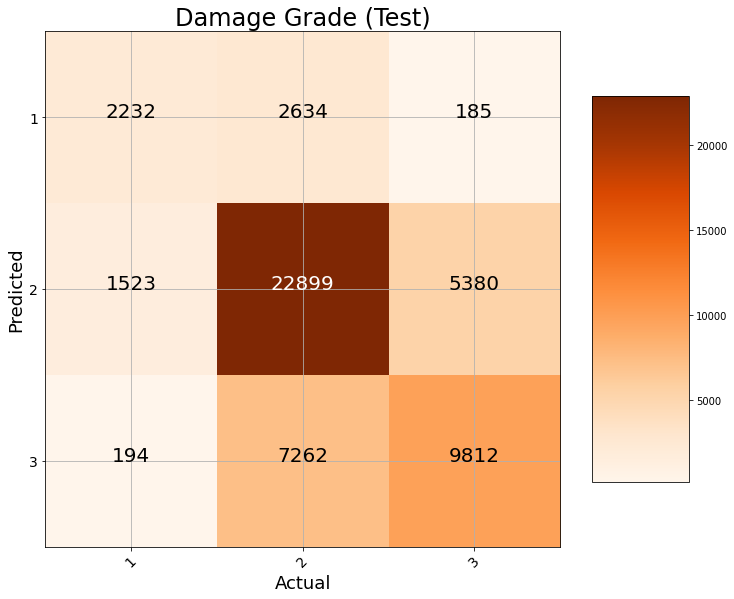

In [15]:
# Use the oversampled-model to predict and compare non-processed-train-damage_grade against train-predicted-damage_grade and 
# non-processed-test-damage_grade against test-predicted-damage_grade
# Plot the confusion matrix & calculate F1 Micro score

nodrop_train_report, f1_nodrop_train = exec_predict_randomForest(train_x_keep, train_y_keep, rf_model_nodrop, "Train")
nodrop_test_report, f1_nodrop_test = exec_predict_randomForest(test_x_keep, test_y_keep, rf_model_nodrop, "Test")

# Random Forest Observation Processed Dataset vs Original Dataset w/ all Features
[Back to top](#Contents)<br>

In [16]:
print("With all features except geo level 2 & 3 : ")
print("Train : ")
print(nodrop_train_report)
print("F1 Micro Score \t\t: " + str(f1_nodrop_train))
print()
print("Test : ")
print(nodrop_test_report)
print("F1 Micro Score \t\t: " + str(f1_nodrop_test))
print()
print("With some features dropped : ")
print("Train : ")
print(normal_train_report)
print("F1 Micro Score \t\t: " + str(f1_normal_train))
print()
print("Test : ")
print(normal_test_report)
print("F1 Micro Score \t\t: " + str(f1_normal_test))

With all features except geo level 2 & 3 : 
Train : 
              precision    recall  f1-score   support

           1       0.95      0.90      0.92     20073
           2       0.93      0.95      0.94    118457
           3       0.92      0.89      0.91     69950

    accuracy                           0.93    208480
   macro avg       0.93      0.91      0.92    208480
weighted avg       0.93      0.93      0.93    208480

F1 Micro Score 		: 0.9261991557943207

Test : 
              precision    recall  f1-score   support

           1       0.57      0.44      0.50      5051
           2       0.70      0.77      0.73     29802
           3       0.64      0.57      0.60     17268

    accuracy                           0.67     52121
   macro avg       0.63      0.59      0.61     52121
weighted avg       0.67      0.67      0.67     52121

F1 Micro Score 		: 0.6704207517123616

With some features dropped : 
Train : 
              precision    recall  f1-score   support

     

### Observation
The F1 score of the dataset w/ all the features except geo level 2 & 3 seemed to be higher than the processed dataset.

#### Analysis
Dropped features may not be useful as a predictor at first glance, but were still impactful for classification.

#### Conclusion
Since F1 Micro score was selected as to benchmark the accuracy of the model, training the model with the original dataset w/ all features except geo level 2 & 3 will be used for optimization.

# Random Forest Optimization through Random Search
[Back to top](#Contents)<br>

In order to maximize the performance of the random forest, we can perform a random search for better hyperparameters. This will randomly select combinations of hyperparameters from a grid, evaluate them using cross validation on the training data, and return the values that perform the best. <br> <br>
Since the model without oversampling and dropped features have the better F1 micro score, we will use the original dataset w/ all features except geo level 2 & 3 for optimization.

In [29]:
# Optimizing the Random Forest Model will take 1h~ so we will just load the already trained model

# import pickle
# with open('../pickle_model/Random_Forest.pickle', 'rb') as f:
#      optimized_model = pickle.load(f)

In [18]:
# Optimize the model
# Time needed to train estimates to be : 1hr~

optimized_model = optimize_model(train_x_keep, train_y_keep)

In [19]:
# Model parameters after completing RandomSearch
optimized_model

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=11,
                       max_features=0.7999999999999999, max_leaf_nodes=42,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=44, n_jobs=None, oob_score=False,
                       random_state=100, verbose=0, warm_start=False)

Comparing predicted against Train dataset :

Confusion matrix, without normalization
[[ 6839 12900   334]
 [ 4310 97963 16184]
 [  254 34649 35047]]

              precision    recall  f1-score   support

           1       0.60      0.34      0.43     20073
           2       0.67      0.83      0.74    118457
           3       0.68      0.50      0.58     69950

    accuracy                           0.67    208480
   macro avg       0.65      0.56      0.58    208480
weighted avg       0.67      0.67      0.66    208480

F1 Micro Score (Train) :  0.6708029547198772

Comparing predicted against Test dataset :

Confusion matrix, without normalization
[[ 1661  3314    76]
 [ 1077 24698  4027]
 [   63  8600  8605]]

              precision    recall  f1-score   support

           1       0.59      0.33      0.42      5051
           2       0.67      0.83      0.74     29802
           3       0.68      0.50      0.57     17268

    accuracy                           0.67     52121
  

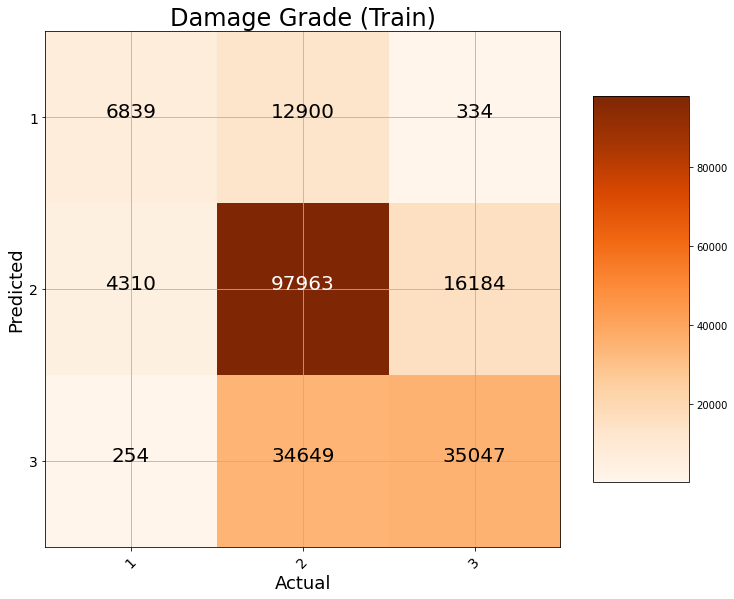

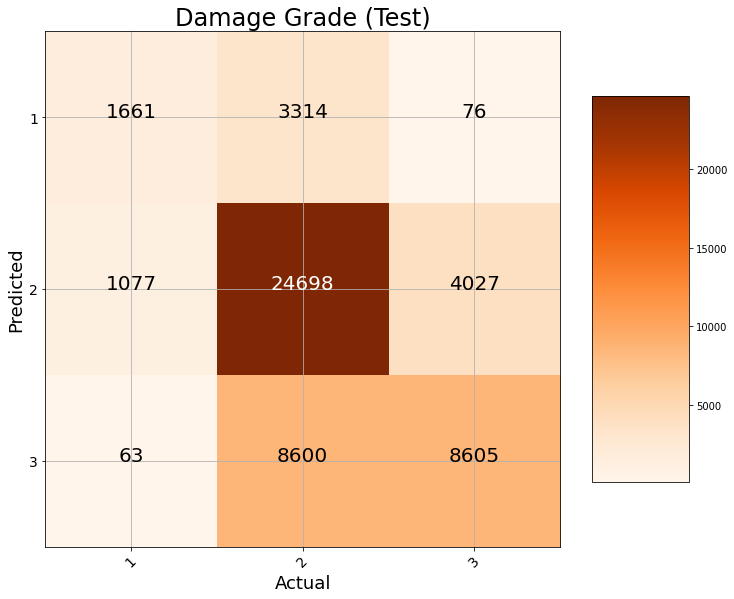

In [20]:
# Use the optimized-model to predict and compare train-damage_grade against train-predicted-damage_grade and 
# test-damage_grade against test-predicted-damage_grade
# Plot the confusion matrix & calculate F1 Micro score

optimized_train_report, f1_optimized_train = exec_predict_randomForest(train_x_keep, train_y_keep, optimized_model, "Train")
optimized_test_report, f1_optimized_test = exec_predict_randomForest(test_x_keep, test_y_keep, optimized_model, "Test")

In [31]:
# Dump model using pickle to prevent having the need to train it again

# import pickle
# with open('../pickle_model/Random_Forest.pickle', 'wb') as f:
#     pickle.dump(optimized_model, f)

## Random Forest Optimzied Model Observation
[Back to top](#Contents)<br>

In [22]:
# Formulate feature list in order of importance
features = train_x_keep.columns
fi_model_rf = pd.DataFrame({'feature': features,
                   'importance': rf_model_nodrop.feature_importances_}).sort_values('importance', ascending = False)
fi_model_optimized = pd.DataFrame({'feature': features,
                   'importance': optimized_model.feature_importances_}).sort_values('importance', ascending = False)

fi_model_rf = fi_model_rf.sort_index()
fi_model_optimized = fi_model_optimized.sort_index()

In [23]:
# Calculate difference in importance between non-optimized & optimized
count = 0
analysis_df = pd.DataFrame(fi_model_rf['feature'])
diff = []
for i in fi_model_rf['importance']:
    diff.append(abs(i - fi_model_optimized['importance'][count]))
    count += 1

analysis_df = pd.concat([analysis_df, pd.DataFrame(diff, columns = ['importance_diff']), \
                         pd.DataFrame(fi_model_rf['importance']).rename(columns = {'importance' : 'importance_rf'}), \
                         pd.DataFrame(fi_model_optimized['importance']).rename(columns = {'importance' : 'importance_op'})], \
                         axis = 1)
analysis_df = analysis_df.sort_values('importance_diff', ascending = False)
analysis_df.head(25)

,feature,importance_diff,importance_rf,importance_op
44,geo_level_1_id_17,0.252442,0.064523,0.316965
2,area_percentage,0.177446,0.181066,0.003620
1,age,0.167943,0.185040,0.017097
60,foundation_type_r,0.134186,0.011989,0.146175
3,height_percentage,0.090134,0.091356,0.001222
48,geo_level_1_id_21,0.056963,0.012646,0.069609
35,geo_level_1_id_8,0.051942,0.011407,0.063350
68,ground_floor_type_v,0.041999,0.009841,0.051839
45,geo_level_1_id_18,0.035007,0.007572,0.042579
54,geo_level_1_id_27,0.032444,0.007951,0.040395


In [24]:
print("Before Optimization : ")
print("Train : ")
print(nodrop_train_report)
print("F1 Micro Score \t\t: " + str(f1_nodrop_train))
print()
print("Test : ")
print(nodrop_test_report)
print("F1 Micro Score \t\t: " + str(f1_nodrop_test))
print()
print("After Optimization : ")
print("Train : ")
print(optimized_train_report)
print("F1 Micro Score \t\t: " + str(f1_optimized_train))
print()
print("Test : ")
print(optimized_test_report)
print("F1 Micro Score \t\t: " + str(f1_optimized_test))
print()

Before Optimization : 
Train : 
              precision    recall  f1-score   support

           1       0.95      0.90      0.92     20073
           2       0.93      0.95      0.94    118457
           3       0.92      0.89      0.91     69950

    accuracy                           0.93    208480
   macro avg       0.93      0.91      0.92    208480
weighted avg       0.93      0.93      0.93    208480

F1 Micro Score 		: 0.9261991557943207

Test : 
              precision    recall  f1-score   support

           1       0.57      0.44      0.50      5051
           2       0.70      0.77      0.73     29802
           3       0.64      0.57      0.60     17268

    accuracy                           0.67     52121
   macro avg       0.63      0.59      0.61     52121
weighted avg       0.67      0.67      0.67     52121

F1 Micro Score 		: 0.6704207517123616

After Optimization : 
Train : 
              precision    recall  f1-score   support

           1       0.60      0.34 

### Observation
The optimization result was a RandomForestClassifier with n_estimators = 44 (Number of trees), max depth = 11 and maximum features = 0.8.  <br>
The optimization slightly increased the F1 Micro Score. <br>

Cross-validation also decreased the importance for non-important predictors like count_families and increased importance for more important predictors like foundation_type_r and ground_floor_type_v. <br>

# Submit for competition

In [25]:
competition_predictions_optimized = optimized_model.predict(test_values_keep)
competition_predictions_nodrop = rf_model_nodrop.predict(test_values_keep)
competition_predictions = rf_model.predict(test_values)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


In [26]:
id_df = pd.read_csv('data/test.csv')

In [27]:
result_optimized = pd.DataFrame({'building_id':id_df['building_id'], 'damage_grade': competition_predictions_optimized.astype(int)})
result_nodrop = pd.DataFrame({'building_id':id_df['building_id'], 'damage_grade': competition_predictions_nodrop.astype(int)})
result = pd.DataFrame({'building_id':id_df['building_id'], 'damage_grade': competition_predictions.astype(int)})

In [28]:
result.to_csv('results.csv', index=False)
result_nodrop.to_csv('results_nodrop.csv', index=False)
result_optimized.to_csv('results_optimized.csv', index=False)

### Competition Score (Processed Model) = 0.6551
### Competition Score (Original Model w/ all features) = 0.6698
### Competition Score (Optimized Model) = 0.6701

# Overall Conclusion
[Back to top](#Contents)<br>

Despite the similar F1 Micro score we obtained for the non-optimized model compared to the optimized model, results from the competition says the otherwise. The F1 Micro score for the optimized model was more consistent between the competition and our results when working with an unseen dataset. This suggest overfitting for the non-optimized model. <br><br>

##### Versatile
What we learnt is that Random Forest Classifier is versatile because it can handle binary, categorial and numerial features with very little pre-processing. However in this project, pre-processing was still done with the attempt of increasing the overall accuracy and reducing the training time of the models. 

##### Overfitting
Random Forest Classifier models are also very fast to train, but they overfit easily without cross validation. 

##### Hardware issue
For large datasets such as the oversampled dataset that we used, large amount of memory was needed and memory allocation error was often encountered so we had to switch to a better computer.